In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aditirawat571","key":"306b61557a0b1a8868289f2c27af890f"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yufengdev/bbc-fulltext-and-category
!unzip bbc-fulltext-and-category.zip


Dataset URL: https://www.kaggle.com/datasets/yufengdev/bbc-fulltext-and-category
License(s): CC0-1.0
  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 552MB/s]
Archive:  bbc-fulltext-and-category.zip
  inflating: bbc-text.csv            


In [3]:
import pandas as pd

df = pd.read_csv("bbc-text.csv")
df = df[df["category"].isin(["sport", "politics"])]

df = df.rename(columns={"text": "text", "category": "label"})
df["label"] = df["label"].map({"sport": 0, "politics": 1})

df.head()


,label,text
2,0,tigers wary of farrell gamble leicester say ...
3,0,yeading face newcastle in fa cup premiership s...
5,1,howard hits back at mongrel jibe michael howar...
6,1,blair prepares to name poll date tony blair is...
7,0,henman hopes ended in dubai third seed tim hen...


In [4]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(stop_words="english", max_features=5000)
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)



In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [7]:
tfidf_ngram = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    max_features=10000
)

X_train_ngram = tfidf_ngram.fit_transform(X_train)
X_test_ngram = tfidf_ngram.transform(X_test)


In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [9]:
def evaluate(model, X_train, X_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    p, r, f, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary"
    )

    return [name, acc, p, r, f]


In [10]:
results = []

results.append(evaluate(MultinomialNB(), X_train_bow, X_test_bow, "Naive Bayes (BoW)"))
results.append(evaluate(LogisticRegression(max_iter=1000), X_train_tfidf, X_test_tfidf, "Logistic Regression (TF-IDF)"))
results.append(evaluate(LinearSVC(), X_train_ngram, X_test_ngram, "SVM (TF-IDF N-gram)"))


In [11]:
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

results_df


,Model,Accuracy,Precision,Recall,F1-score
0,Naive Bayes (BoW),0.994624,0.988235,1.000000,0.994083
1,Logistic Regression (TF-IDF),0.994624,1.000000,0.988095,0.994012
2,SVM (TF-IDF N-gram),1.000000,1.000000,1.000000,1.000000


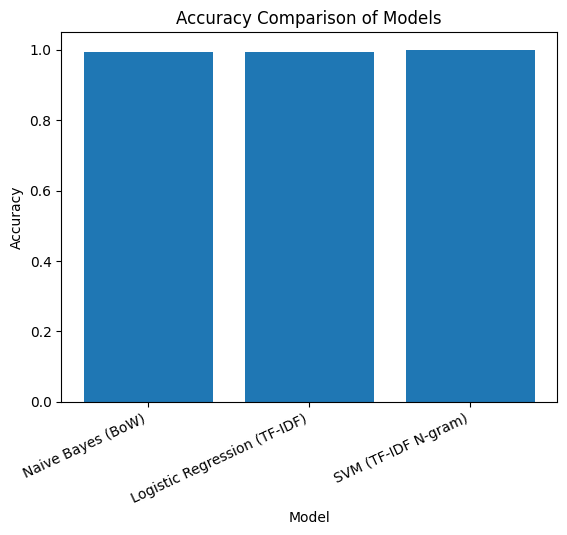

In [13]:
plt.figure()
plt.bar(results_df["Model"], results_df["Accuracy"])
plt.xticks(rotation=25, ha="right")
plt.title("Accuracy Comparison of Models")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.show()


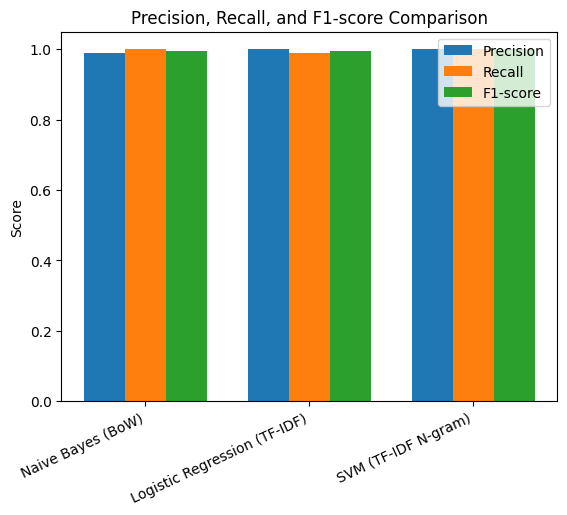

In [14]:
import numpy as np

x = np.arange(len(results_df))
width = 0.25

plt.figure()
plt.bar(x - width, results_df["Precision"], width, label="Precision")
plt.bar(x, results_df["Recall"], width, label="Recall")
plt.bar(x + width, results_df["F1-score"], width, label="F1-score")

plt.xticks(x, results_df["Model"], rotation=25, ha="right")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score Comparison")
plt.legend()
plt.show()
